In [1]:
## Importing libraries
from __future__ import print_function
import torch
from torch import nn, optim
from torchvision import datasets, utils as vutils, transforms
from torch.autograd import Variable
import time
import numpy as np

In [2]:
## Setting some hyperparameters
batch_size = 64
image_size = 64

## Creating the transformation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

## Loading the dataset
dataset = datasets.CIFAR10(root="./data", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


In [3]:
## Defining the weights_init function that takes as input a neural network m and that will initialize its weights

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [4]:
## defining the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, inputs):
        return self.main(inputs)
    
## Creating the generator
generator = Generator()
generator.to(device) 
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [5]:
## Defining the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.main(inputs).view(-1)
    
## Creating the discriminator
discriminator = Discriminator()
discriminator.to(device)

discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [6]:
## Training the DCGANs
criterion = nn.BCELoss()
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

n_epochs = 10 # You can set this even higher but this can lead the model to overfitting

In [7]:
%%time

is_better = False
best_loss_G = np.inf
best_loss_D = np.inf
for epoch in range(1, n_epochs+1):
    for step, (images, _ ) in enumerate(dataloader, 1):

        # 1st Step: Updating the weights of the neural network of the discriminator
        discriminator.zero_grad()
        # Training the discriminator with a real image of the dataset
        inputs = Variable(images)
        target = Variable(torch.ones(inputs.size()[0]))
        inputs, target = inputs.to(device), target.to(device)
        output = discriminator(inputs)
        loss_D_real = criterion(output, target)
        # Training the discriminator with a fake image generated by the generator
        noise = Variable(torch.randn(inputs.size()[0], 100, 1, 1))
        target = Variable(torch.zeros(inputs.size()[0]))
        noise, target = noise.to(device), target.to(device)
        fake = generator(noise)
        output = discriminator(fake.detach())
        loss_D_fake = criterion(output, target)
        # Backpropagating the total loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()

        # 2nd Step: Updating the weights of the neural network of the generator
        generator.zero_grad()
        target = Variable(torch.ones(inputs.size()[0]))
        target = target.to(device)
        output = discriminator(fake)
        loss_G = criterion(output, target)
        loss_G.backward()
        optimizer_G.step()
        
        if step%100 == 0 or step == 1:
            # Saving the real images and the generated images every 100 steps
            print("[%d/%d][%d/%d] Loss_D: %.4f, Loss_G: %.4f"%(epoch, n_epochs, step, len(dataloader), loss_D.item(), loss_G.item()))
            vutils.save_image(images, "%s/epoch_%03d_real_samples.png"% ("./results", epoch), normalize=True)
            with torch.no_grad():
                fake = generator(noise)
            vutils.save_image(fake.data, "%s/epoch_%03d_fake_samples.png"% ("./results", epoch), normalize=True)
    
        ## Check and Save the best generator and discriminator after each batch, I mean at each step
        is_better = best_loss_D > loss_D.item() and best_loss_G > loss_G.item()
        if is_better:
            print("Saving models ...")
            torch.save(discriminator, "discriminator_best.pt")
            torch.save(generator, "generator_best.pt")
            best_loss_D, best_loss_G =  loss_D.item(), loss_G.item()
            
torch.save(discriminator, "discriminator.pt")
torch.save(generator, "generator.pt")

[1/10][1/782] Loss_D: 1.9468, Loss_G: 7.0671
Saving models ...
Saving models ...
[1/10][100/782] Loss_D: 0.4701, Loss_G: 5.4700
Saving models ...
Saving models ...
Saving models ...
[1/10][200/782] Loss_D: 0.5004, Loss_G: 7.1881
[1/10][300/782] Loss_D: 0.3275, Loss_G: 5.8970
[1/10][400/782] Loss_D: 0.6089, Loss_G: 4.3291
[1/10][500/782] Loss_D: 0.4014, Loss_G: 2.8829
[1/10][600/782] Loss_D: 1.1211, Loss_G: 2.3939
[1/10][700/782] Loss_D: 1.5319, Loss_G: 3.0491
[2/10][1/782] Loss_D: 0.6190, Loss_G: 4.3984
[2/10][100/782] Loss_D: 1.1178, Loss_G: 2.5183
[2/10][200/782] Loss_D: 0.6674, Loss_G: 2.8712
[2/10][300/782] Loss_D: 0.4454, Loss_G: 2.9679
[2/10][400/782] Loss_D: 0.6354, Loss_G: 5.3234
[2/10][500/782] Loss_D: 0.5368, Loss_G: 3.3669
[2/10][600/782] Loss_D: 0.8804, Loss_G: 2.9831
[2/10][700/782] Loss_D: 0.7540, Loss_G: 4.6465
[3/10][1/782] Loss_D: 0.7684, Loss_G: 4.2023
[3/10][100/782] Loss_D: 0.9091, Loss_G: 4.5342
[3/10][200/782] Loss_D: 0.2865, Loss_G: 3.7891
[3/10][300/782] Loss_D:

In [41]:

def test(n_images = 30):
    """
    Take a number of desired generated images and generates and displays them with their probability of 
    being real calculated by the discriminator.
    
    n_images: upto 30 by preference for display purpose
    """
    ## Load the saved the generator and discriminator
    discriminator = torch.load("discriminator.pt")
    generator = torch.load("generator.pt")

    noise = torch.randn(n_images, 100, 1, 1)

    with torch.no_grad():
        fake = generator(noise)
        output = discriminator(fake)

    import matplotlib.pyplot as plt
    plt.rcParams.update({'axes.titlesize': 25})

    fig = plt.figure(figsize=(25,25))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(n_images):
        img = fake[i].detach().numpy().squeeze().transpose((2,1,0))
        ax = fig.add_subplot(5, 6, i + 1, xticks=[], yticks=[])
        ax.set_title("Real: {:.2%} ".format(output[i]))
        img = np.clip(img, 0, 1)
        ax.imshow(img)


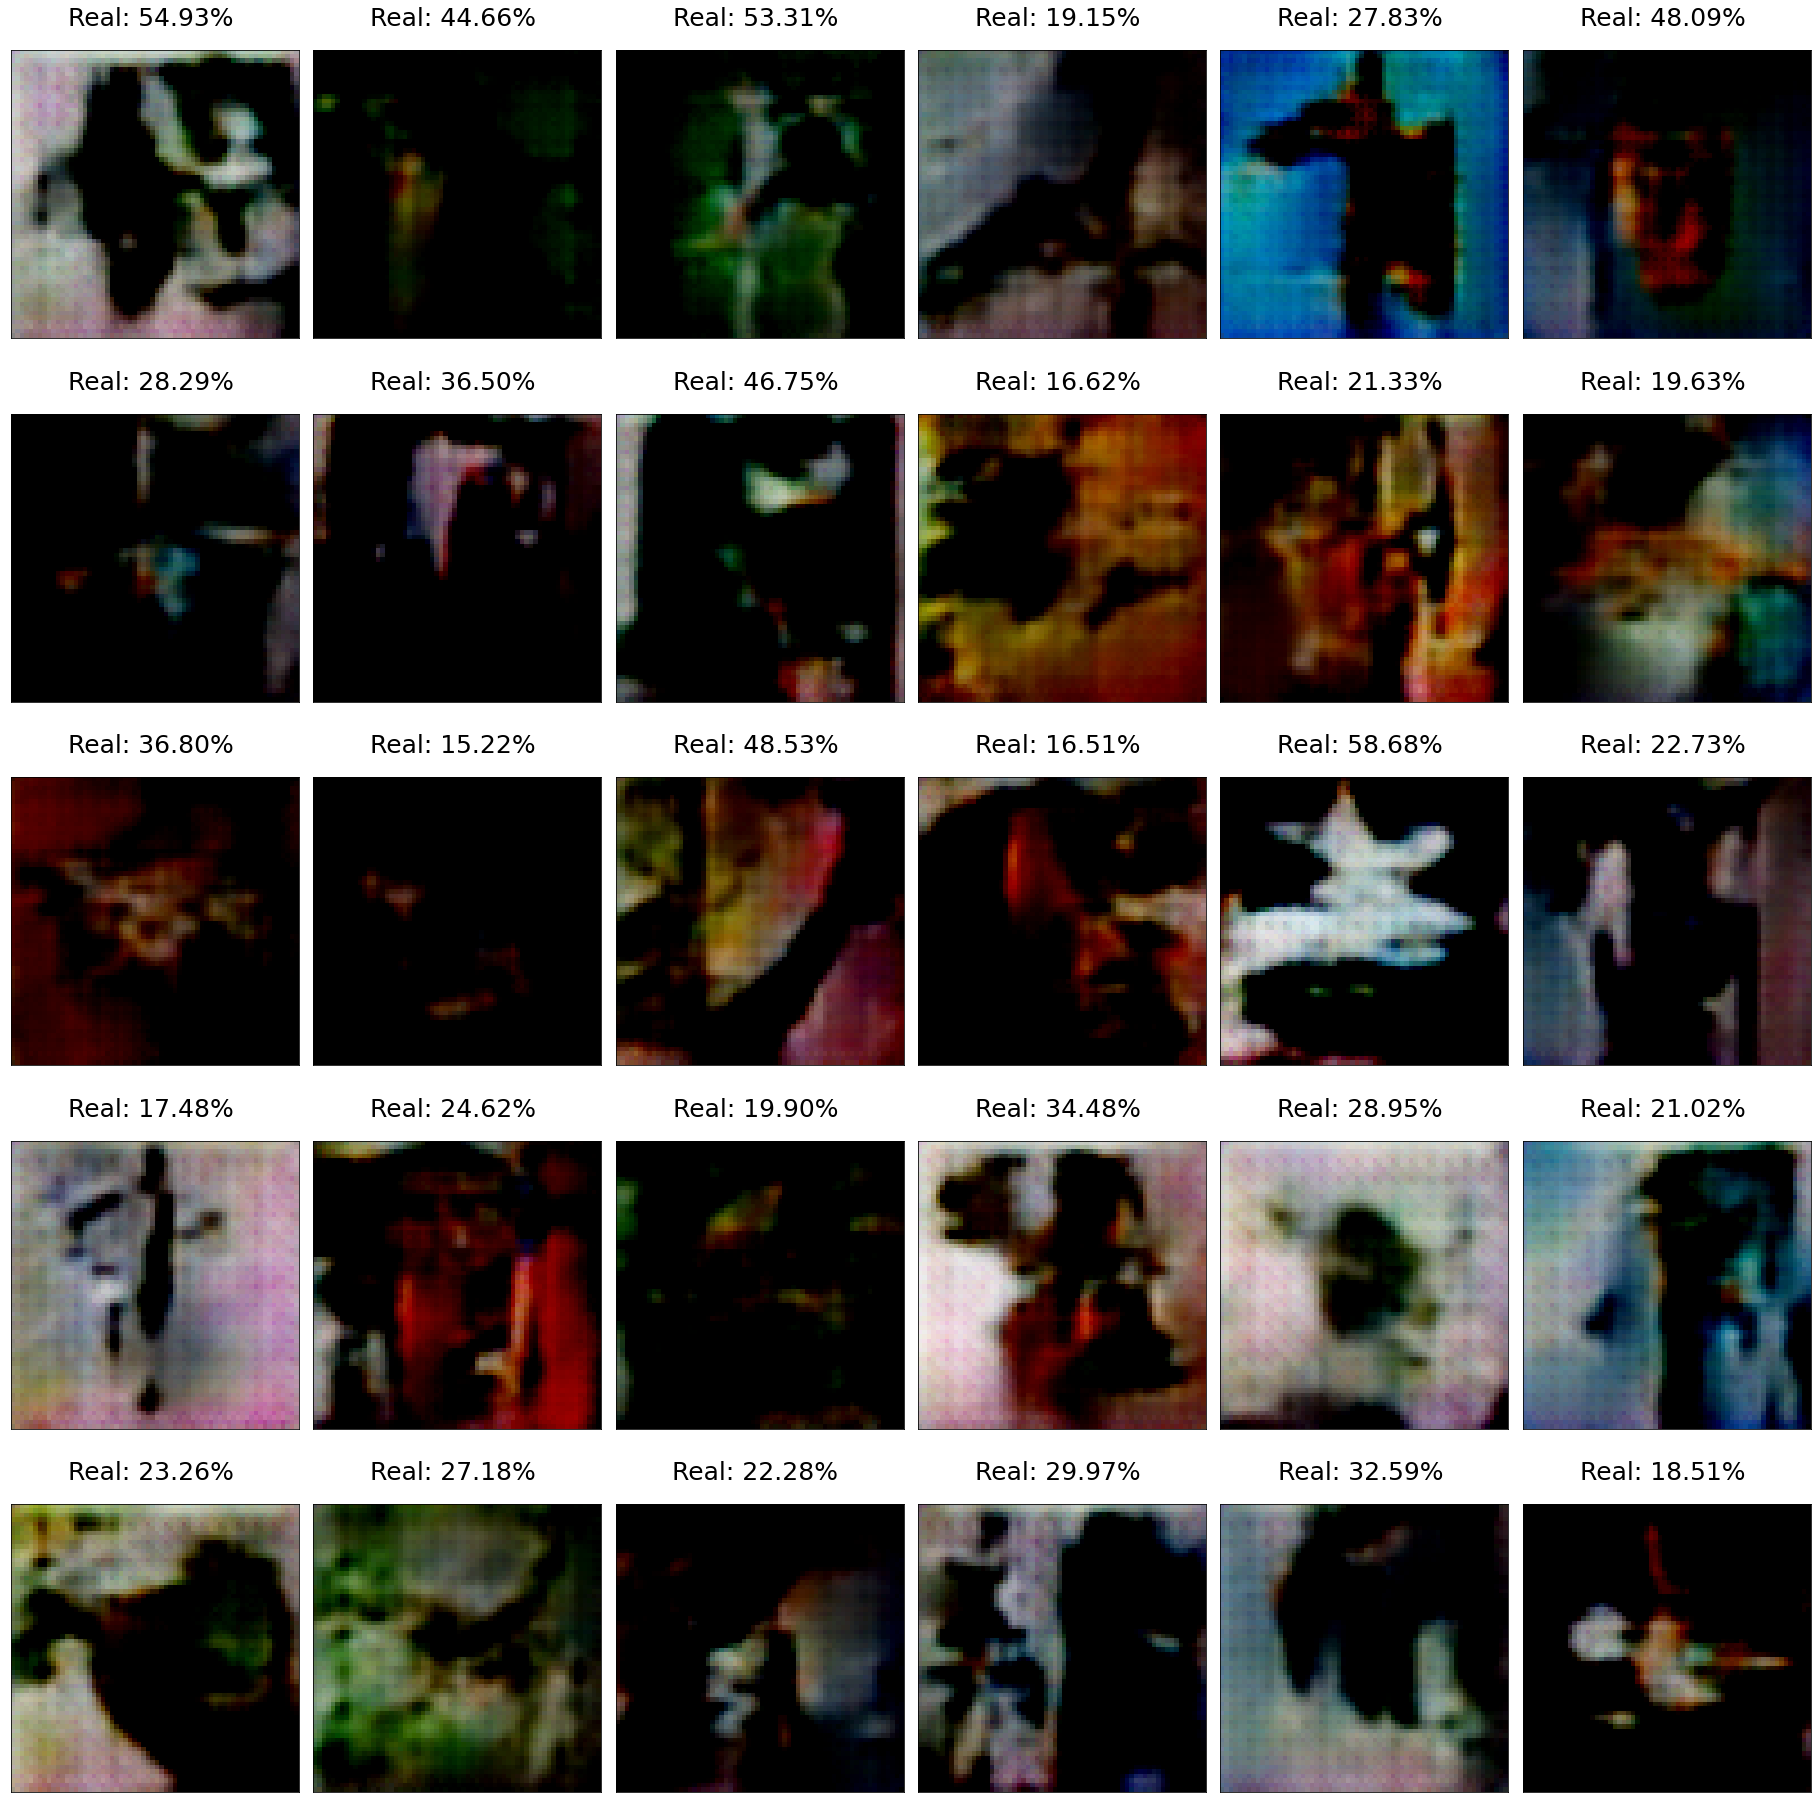

In [42]:
# To display 30 generated images
test()